In [1]:
# import some important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.listdir("HWI"))
#import warnings
#warnings.filterwarnings('ignore')

['train.xlsm', 'draft_1.ipynb', 'sample_submission.csv', 'test', 'train', 'train.csv', '.ipynb_checkpoints']


In [2]:
from keras import backend as k
k.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import tensorflow as tf
import random
import time
import cv2

from skimage import io
from pylab import rcParams

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import data, color

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift,img_to_array, ImageDataGenerator)

import numpy as np
import pandas as pd

import warnings
from glob import glob

print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 1.12.0
Keras version: 2.2.4


In [4]:
TRAIN_IMAGE_PATH = "HWI/train/"
TEST_IMAGE_PATH = "HWI/test/"
TRAINING_DATA='HWI/train.csv'
IMG_SIZE = 64

In [5]:
df_train = pd.read_csv(TRAINING_DATA)
#print(df_train.iloc[0]['Id'])
#df_train.index.name = 'index'
#df_train = df_train.query('index < 10000')
del_ind = []

for i in range(len(df_train)):
    if df_train.iloc[i]['Id'] == 'new_whale':
        del_ind.append(i)
df_train = df_train.drop(df_train.index[del_ind])
print(len(df_train))

#string to unique int
#set unique int value for each unique classes sring.. string to int
unique_calsses_value = np.unique(df_train[['Id']].values)
#unique_calsses_value = np.delete(unique_calsses_value,[0])
print(unique_calsses_value)
unique_classes_id_dict = {}
unique_id_classes_dict = {}
for i in range(len(unique_calsses_value)):
    unique_classes_id_dict[unique_calsses_value[i]] = i
    unique_id_classes_dict[i] = unique_calsses_value[i]
print(len(unique_id_classes_dict))

15697
['w_0003639' 'w_0003c59' 'w_0027efa' ... 'w_ffa6d42' 'w_ffcf5fe'
 'w_ffe8693']
5004


In [6]:
df_train['classes_id'] = df_train.apply (lambda row: unique_classes_id_dict.get(row['Id']),axis=1)

#df_train = df_train.dropna()
df_train.head(15)
len(df_train)

15697

In [7]:
def show_image(image):
    plt.imshow(image)
def plot_images(images):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(9, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i])
    plt.show()   

In [8]:
#resize the image
def LoadImage(img_path):
    image = color.rgb2gray(io.imread(img_path))
    image_resized = resize(image,(IMG_SIZE,IMG_SIZE),mode='constant')
    return image_resized[:,:] / 255.
#load  images data and classes id
def LoadImageData(path):
    xs = []
    ys = []
    #for ex_paths in paths:
    for index, row in df_train.iterrows():        
        img_path = path + row['Image']
        igm = LoadImage(img_path)
        xs.append(igm)
        ys.append(row['classes_id'])
        if index%1000 == 0:
            print(index+1)
    return np.array(xs),np.array(ys)

In [9]:
X_train,Y_train = LoadImageData(TRAIN_IMAGE_PATH)
print("Loaded")

1
1001
2001
3001
4001
5001
6001
7001
8001
13001
14001
15001
18001
19001
21001
24001
Loaded


In [10]:
print("X_train ",X_train.shape)
print("Y_train ",Y_train.shape)
print("X_train ",len(df_train))
print("y_train ",Y_train)

X_train  (15697, 64, 64)
Y_train  (15697,)
X_train  15697
y_train  [4785 3807  661 ... 3058 3670 3102]


XS  [4070, 14213, 11417, 8473, 9712, 6107, 12605, 12606, 5584]


<Figure size 1008x576 with 0 Axes>

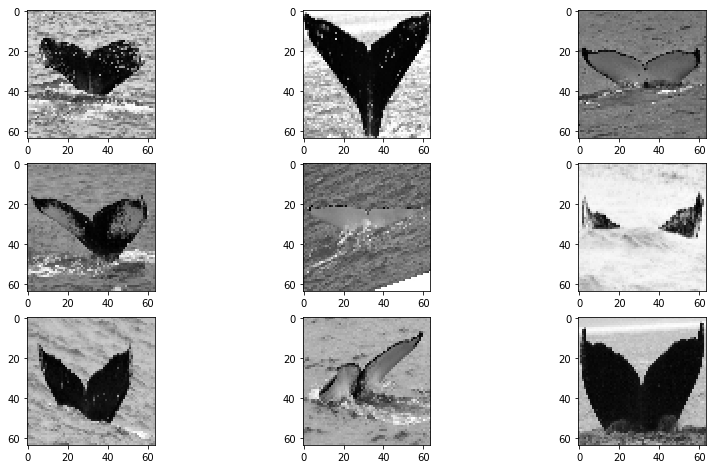

In [11]:
xs = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]   
print("XS ",xs)
plot_images(X_train[xs])

In [12]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#change the classes id to 0 1 format
Y_train = keras.utils.to_categorical(Y_train,num_classes=len(unique_classes_id_dict))

print(np.shape(X_train))
print(np.shape(Y_train))

(15697, 64, 64, 1)
(15697, 5004)


In [23]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to create a cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = (1, 1), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(BatchNormalization(axis = 3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), strides = (1,1)))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.6))
model.add(Dense(len(unique_id_classes_dict), activation='softmax'))
model.summary()

# Define the optimizer
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 9, 9, 64)          0         
__________

In [29]:
epochs = 64  # for better result increase the epochs
batch_size = 128

In [30]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[learning_rate_reduction])

Epoch 1/20
 - 6s - loss: 0.4512 - acc: 0.8616
Epoch 2/20


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 6s - loss: 0.4558 - acc: 0.8590
Epoch 3/20
 - 6s - loss: 0.4682 - acc: 0.8547
Epoch 4/20
 - 6s - loss: 0.4502 - acc: 0.8601
Epoch 5/20
 - 6s - loss: 0.4754 - acc: 0.8539
Epoch 6/20
 - 6s - loss: 0.4558 - acc: 0.8588
Epoch 7/20
 - 6s - loss: 0.4627 - acc: 0.8572
Epoch 8/20
 - 6s - loss: 0.4547 - acc: 0.8606
Epoch 9/20
 - 6s - loss: 0.4765 - acc: 0.8513
Epoch 10/20
 - 6s - loss: 0.4361 - acc: 0.8644
Epoch 11/20
 - 6s - loss: 0.4603 - acc: 0.8609
Epoch 12/20
 - 6s - loss: 0.4559 - acc: 0.8563
Epoch 13/20
 - 6s - loss: 0.4574 - acc: 0.8585
Epoch 14/20
 - 6s - loss: 0.4353 - acc: 0.8641
Epoch 15/20
 - 6s - loss: 0.4289 - acc: 0.8644
Epoch 16/20
 - 6s - loss: 0.4206 - acc: 0.8698
Epoch 17/20
 - 6s - loss: 0.4501 - acc: 0.8607
Epoch 18/20
 - 6s - loss: 0.4181 - acc: 0.8726
Epoch 19/20
 - 6s - loss: 0.4383 - acc: 0.8604
Epoch 20/20
 - 6s - loss: 0.4330 - acc: 0.8674


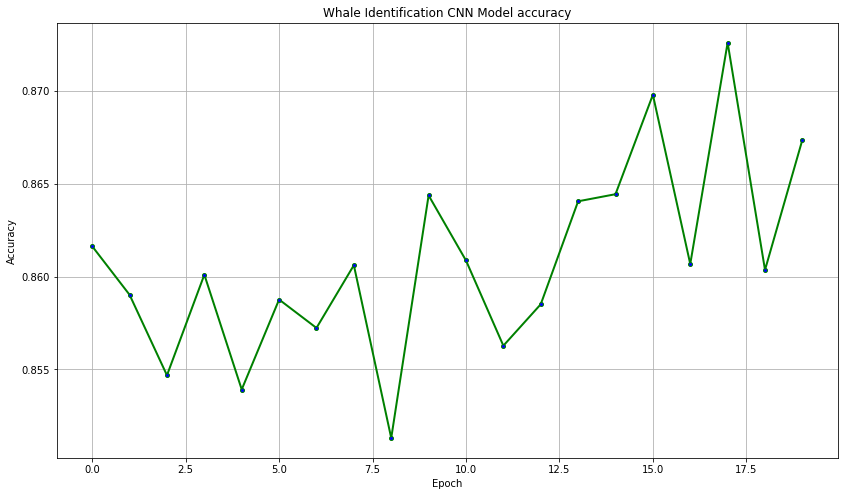

In [31]:
plt.plot(history.history['acc'], color='green', linewidth = 2, 
         marker='o', markerfacecolor='blue', markersize=4) 
plt.title('Whale Identification CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

In [32]:
SUBMISSION_FILE="submission_4.csv"

def getLabel(classes):
    result = []
    for i in range(0, len(classes)):
        _class = unique_id_classes_dict.get(classes[i])
        result.append(_class)
    return result

with open(SUBMISSION_FILE,"w") as f:
    test_imgs = glob("HWI/test/*jpg")
    f.write("Image,Id\n")
    for image in test_imgs:
        #print(image)
        igm = LoadImage(image)
        X_test = np.array(igm)
        X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
        Y_test = model.predict_proba(X_test,batch_size=1)
        best_predict_5 = np.argsort(Y_test)[0][::-1][:5]
        pre = getLabel(best_predict_5)
        #print(image, " ".join( pre))
        f.write("%s,%s\n" %(os.path.basename(image), " ".join( pre)))
print("csv created")

csv created
